In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys


[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA

min_nblocks = 3       # min number of blocks for a session to be include
max_ndays   = 30      # accept all pairs of sessions regardless of time between
min_r       = 0.33    # subselect days where mean recalibration alone works okayish
sigma       = 2       # causal gaussian smoothing for TXs
task        = None    # subselect any tasks
train_size  = 0.67    # fraction of blocks for training data
gridSize    = 20      

data_dir    = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/'
participant = 'T5/new/'
save_path   = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/T5/test/'


# load data:
files       = loadDataset(data_dir, participant)

# preprocess by selecting sessions with a minimal block count:
sessions_check = np.load('../utils/misc_data/NewSessions_check.npy', allow_pickle = True).item()
files          = get_Sessions(files, min_nblocks, manually_remove = None)

pairs    = get_SessionPairs(files, max_ndays = max_ndays)
n_pairs  = len(pairs)

Now generate dictionaries containing data for session-pairs, and save to dataset folder:

In [2]:
def getScreenBounds(struct):
    targpos_data  = struct.targetPos_continuous
    X_min, X_max  = targpos_data[:, 0].min() - 20, targpos_data[:, 0].max() + 20
    Y_min, Y_max  = targpos_data[:, 1].min() - 20, targpos_data[:, 1].max() + 20
    
    return X_min, X_max, Y_min, Y_max


In [11]:
from hmm import *
from hmm_utils import prep_HMMData, get_DiscreteTargetGrid, train_HMMRecalibrate
import scipy, sklearn
import itertools

pearsons = list()
R2s      = list()

for i, (A_file, B_file) in enumerate(pairs):
    dayA = DataStruct(A_file, alignScreens = True, causal_filter = sigma)
    dayB = DataStruct(B_file, alignScreens = True, causal_filter = sigma)
    

    #dayA_blocks             = [sessions_check[A_file] if A_file in sessions_check.keys() else None][0]
    #dayB_blocks             = [sessions_check[B_file] if B_file in sessions_check.keys() else None][0] 
    #dayA_task, dayB_task, _ = getPairTasks(dayA, dayB, task = task)
    dayA_blocks, dayB_blocks = None, None
    dayA_task, dayB_task    = None, None

    # obtain features and cursorError targets:
    Atrain_x, Atest_x, Atrain_y, Atest_y  = getTrainTest(dayA, train_size = train_size, blocks = dayA_blocks, task = dayA_task, returnFlattened = True)    
    Atrain_x, Atest_x  = get_BlockwiseMeanSubtracted(Atrain_x, Atest_x, concatenate = True)
    Atrain_y           = np.concatenate(Atrain_y)
    Atest_y            = np.concatenate(Atest_y)

    Btrain_x, Btest_x, Btrain_y, Btest_y, B_cursorPos, _  = getTrainTest(dayB, train_size = train_size, blocks = dayB_blocks, task = dayB_task, 
                                                                         returnFlattened = True, returnCursor = True)    

    Btrain_x, Btest_x  = get_BlockwiseMeanSubtracted(Btrain_x, Btest_x, concatenate = True)
    Btrain_y           = np.concatenate(Btrain_y)
    Btest_y            = np.concatenate(Btest_y)
    B_cursorPos        = np.concatenate(B_cursorPos)

    A_decoder = LinearRegression(fit_intercept = False, normalize = False).fit(Atrain_x, Atrain_y)
    Bpred_y   = A_decoder.predict(Btest_x)
    
    R2score  = sklearn.metrics.r2_score(Btest_y, Bpred_y)
    pearsonr = scipy.stats.pearsonr(Btest_y.flatten(), Bpred_y.flatten())[0]
    
    pearsons.append(pearsonr)
    R2s.append(R2score)
    
    if pearsonr >= min_r:
        # add smoothing and session-specific information
        pair_data = dict()
        pair_data['A_file']     = A_file
        pair_data['B_file']     = B_file
        pair_data['days_apart'] = daysBetween(dayA.date, dayB.date)
        pair_data['task']       = task
        pair_data['train_size'] = train_size
        pair_data['smoothing']  = sigma

        pair_data['A_decoder']           = A_decoder
        pair_data['mean_recal_R2']       = R2score
        pair_data['mean_recal_pearsonr'] = pearsonr

        pair_data['A_train_neural']  = Atrain_x
        pair_data['A_test_neural']   = Atest_x
        pair_data['A_train_targvec'] = Atrain_y
        pair_data['A_test_targvec']  = Atest_y

        pair_data['B_train_neural']  = Btrain_x
        pair_data['B_test_neural']   = Btest_x
        pair_data['B_train_targvec'] = Btrain_y
        pair_data['B_test_targvec']  = Btest_y
        pair_data['B_train_cursor']  = B_cursorPos        
        pair_data['B_screenBounds']  = getScreenBounds(dayB)

        save_fname = dayA.date + '_to_' + dayB.date + '.npy'
        np.save(save_path + save_fname, pair_data)

    if (i + 1) % int(np.round(len(pairs) / 10)) == 0:
        print(np.round((i + 1) * 100 / len(pairs), 1), '% complete')

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


9.3 % complete
18.5 % complete
27.8 % complete
37.0 % complete
46.3 % complete
55.6 % complete
64.8 % complete
74.1 % complete
83.3 % complete
92.6 % complete


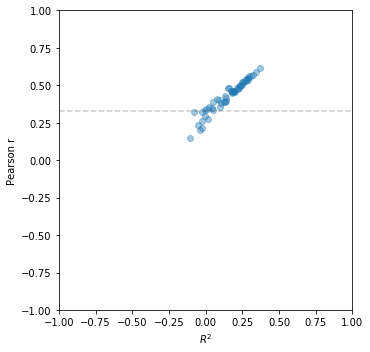

In [7]:
figSize(5, 5)

lims = [-1, 1]
plt.scatter(R2s, pearsons, alpha = 0.4)
plt.axhline(0.33, color = 'k', linestyle = '--', alpha = 0.2)
plt.xlim(lims)
plt.ylim(lims)
plt.show()
plt.xlabel('$R^2$')
plt.ylabel('Pearson r')

plt.tight_layout()


45